In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # alternatively you can use jax or tensorflow as the backend (see installation instructions in keras documentation)
import keras

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # helpful for splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler, MinMaxScaler # helpful for scaling data to be between 0 and 1 or have a mean of 0 and standard deviation of 1


In [2]:
file_path = '/Users/ctychen/Desktop/N3AS/spectrum_data/'
#reloading data
parameters = np.concatenate([np.load(file_path + "atm_retr_params_12800_"+str(i)+".npy") for i in range(12)])
spectra_set = np.concatenate([np.load(file_path + "atm_retr_data_12800_"+str(i)+".npy") for i in range(12)])

#take the log of the spectra - seems like this helped a lot with feature identification
spectra_set = np.log(spectra_set)

parameters = parameters[~np.isnan(spectra_set).any(axis=1)]
spectra_set = spectra_set[~np.isnan(spectra_set).any(axis=1)]

print(parameters.shape)
print(spectra_set.shape)

(153590, 16)
(153590, 947)


In [3]:
n_samples = parameters.shape[0]
n_features = 947 #this is really arbitrary

# ATTEMPT 2: 
#maybe instead of using the standardscaler (or minmaxscaler), we might have to normalize the spectra on our own
#we could do the same (log(flux) - min / (max - min)) normalization that we did for the spectra
#and keep in mind that we are already working with log(flux) spectra. 
max_log_flux = np.max(spectra_set, axis=1)
min_log_flux = np.min(spectra_set, axis=1)
spectra_set = (spectra_set - min_log_flux[:, np.newaxis])/(max_log_flux - min_log_flux)[:, np.newaxis]

#splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(parameters, spectra_set, test_size=0.2)

In [5]:
#attempt 5:
# 512-256-128-32-128-256-512 -- compare how this does to 512-64-32-64-512 from prev tests
inp = keras.layers.Input(shape=(n_features,)) # input layer with n_features neurons
x = keras.layers.Dense(512, activation="relu")(inp) 
x = keras.layers.Dense(256, activation="relu")(x) 
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(32, activation="relu")(x) # (bottleneck layer)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(256, activation="relu")(x) 
x = keras.layers.Dense(512, activation="relu")(x)
out = keras.layers.Dense(n_features)(x) # output layer with n_features neurons
autoencoder = keras.models.Model(inp, out) # create model with input and output layers

# compile model
autoencoder.compile(optimizer="adam", loss="mean_squared_error") # use adam optimizer and mean squared error loss function

# print model summary
autoencoder.summary()

# train model with training data and validate with testing data (early stopping is used to avoid overfitting)
history = autoencoder.fit(y_train, y_train, epochs=500, batch_size=32, validation_data=(y_test, y_test),
                callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # this stops training if the validation loss does not decrease for 5 epochs to avoid overfitting

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 947)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       485,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 947)            │       485,811 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,308,371 (4.99 MB)

 Trainable params: 1,308,371 (4.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.0081 - val_loss: 5.2017e-04
Epoch 2/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 5.3620e-04 - val_loss: 4.3653e-04
Epoch 3/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 4.3129e-04 - val_loss: 3.8610e-04
Epoch 4/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 4.0943e-04 - val_loss: 2.8233e-04
Epoch 5/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 3.3153e-04 - val_loss: 3.3624e-04
Epoch 6/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - loss: 3.0004e-04 - val_loss: 2.6423e-04
Epoch 7/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 2.8775e-04 - val_loss: 2.8394e-04
Epoch 8/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - loss: 2.8138e-04 - val_loss: 2.4672e-04
Epoch 9/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 2.6047e-04 - val_loss: 2.3795e-04
Epoch 10/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - loss: 2.6235e-04 - val_loss: 2.3006e-04
Epoch 11/500
3840/3840 

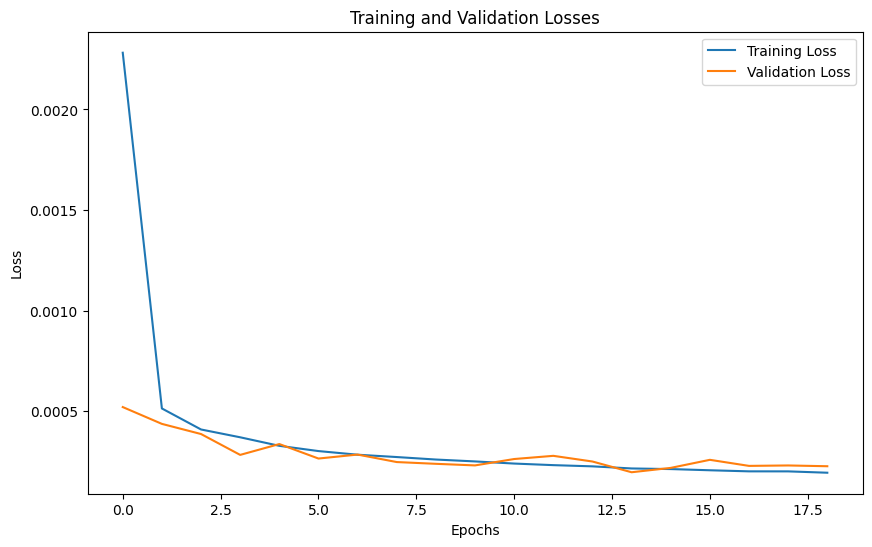

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f'Training and Validation Losses')
plt.legend()
plt.show()

960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.0795e-04
Test Loss: 0.00022594889742322266
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step


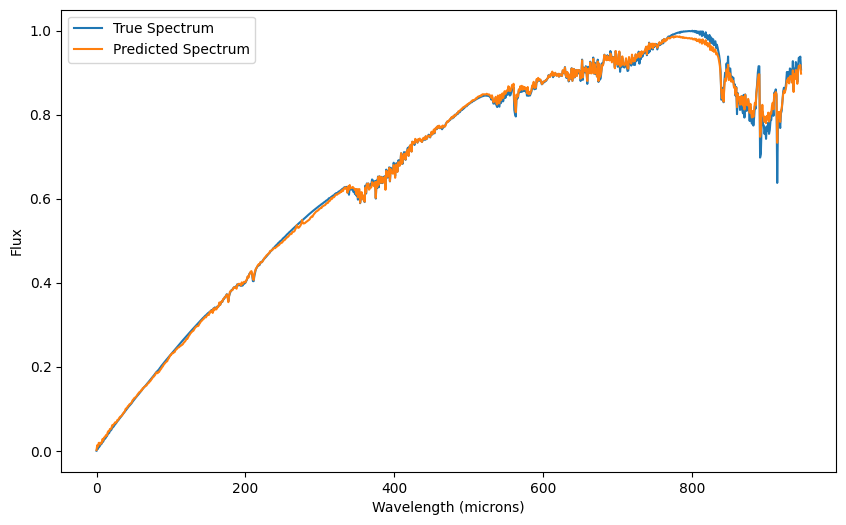

In [7]:
#try evaluating the model with testing data
loss = autoencoder.evaluate(y_test, y_test)
print(f'Test Loss: {loss}')

#example predictions
y_pred = autoencoder.predict(y_test)
# y_pred_unscaled = yscaler.inverse_transform(y_pred) 
# y_test_unscaled = yscaler.inverse_transform(y_test)

# wavelengths = np.linspace(0.95, 2.45, len(y_test_unscaled[0]))
wavelengths = np.linspace(0.95, 2.45, len(y_test[0]))

plt.figure(figsize=(10, 6))
# plt.plot(y_test_unscaled[0], label="True Spectrum")
# plt.plot(y_pred_unscaled[0], label="Predicted Spectrum")
plt.plot(y_test[0], label="True Spectrum")
plt.plot(y_pred[0], label="Predicted Spectrum")
plt.legend()
plt.xlabel("Wavelength (microns)")
plt.ylabel("Flux")
plt.show()

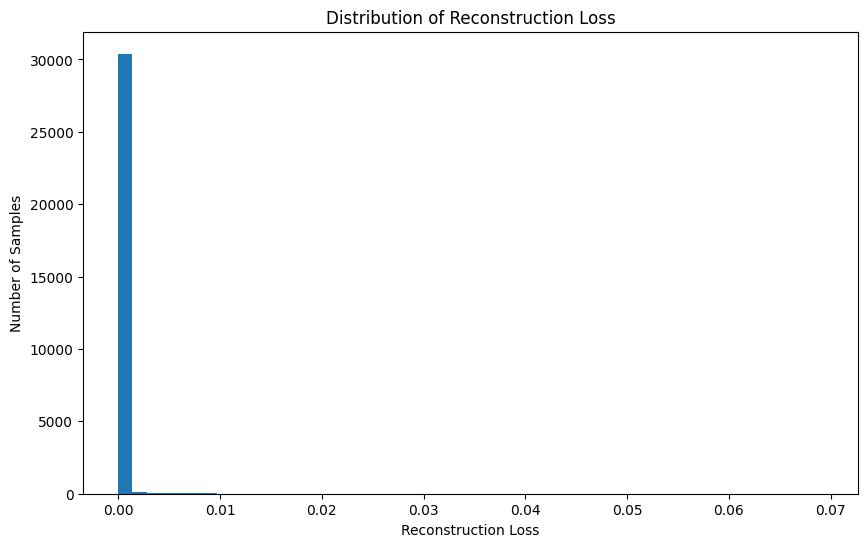

Mean Reconstruction Loss: 0.000225954140881204
Max Reconstruction Loss: 0.0692316752785088
Min Reconstruction Loss: 1.4607340344373179e-05


In [8]:
reconstruction_loss = np.mean((y_pred - y_test)**2, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50)
plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Loss")
plt.show()

print(f'Mean Reconstruction Loss: {np.mean(reconstruction_loss)}')
print(f'Max Reconstruction Loss: {np.max(reconstruction_loss)}')
print(f'Min Reconstruction Loss: {np.min(reconstruction_loss)}')

[12737 12289 20714 16093 26358  8537 23458 12998 10141 29498]


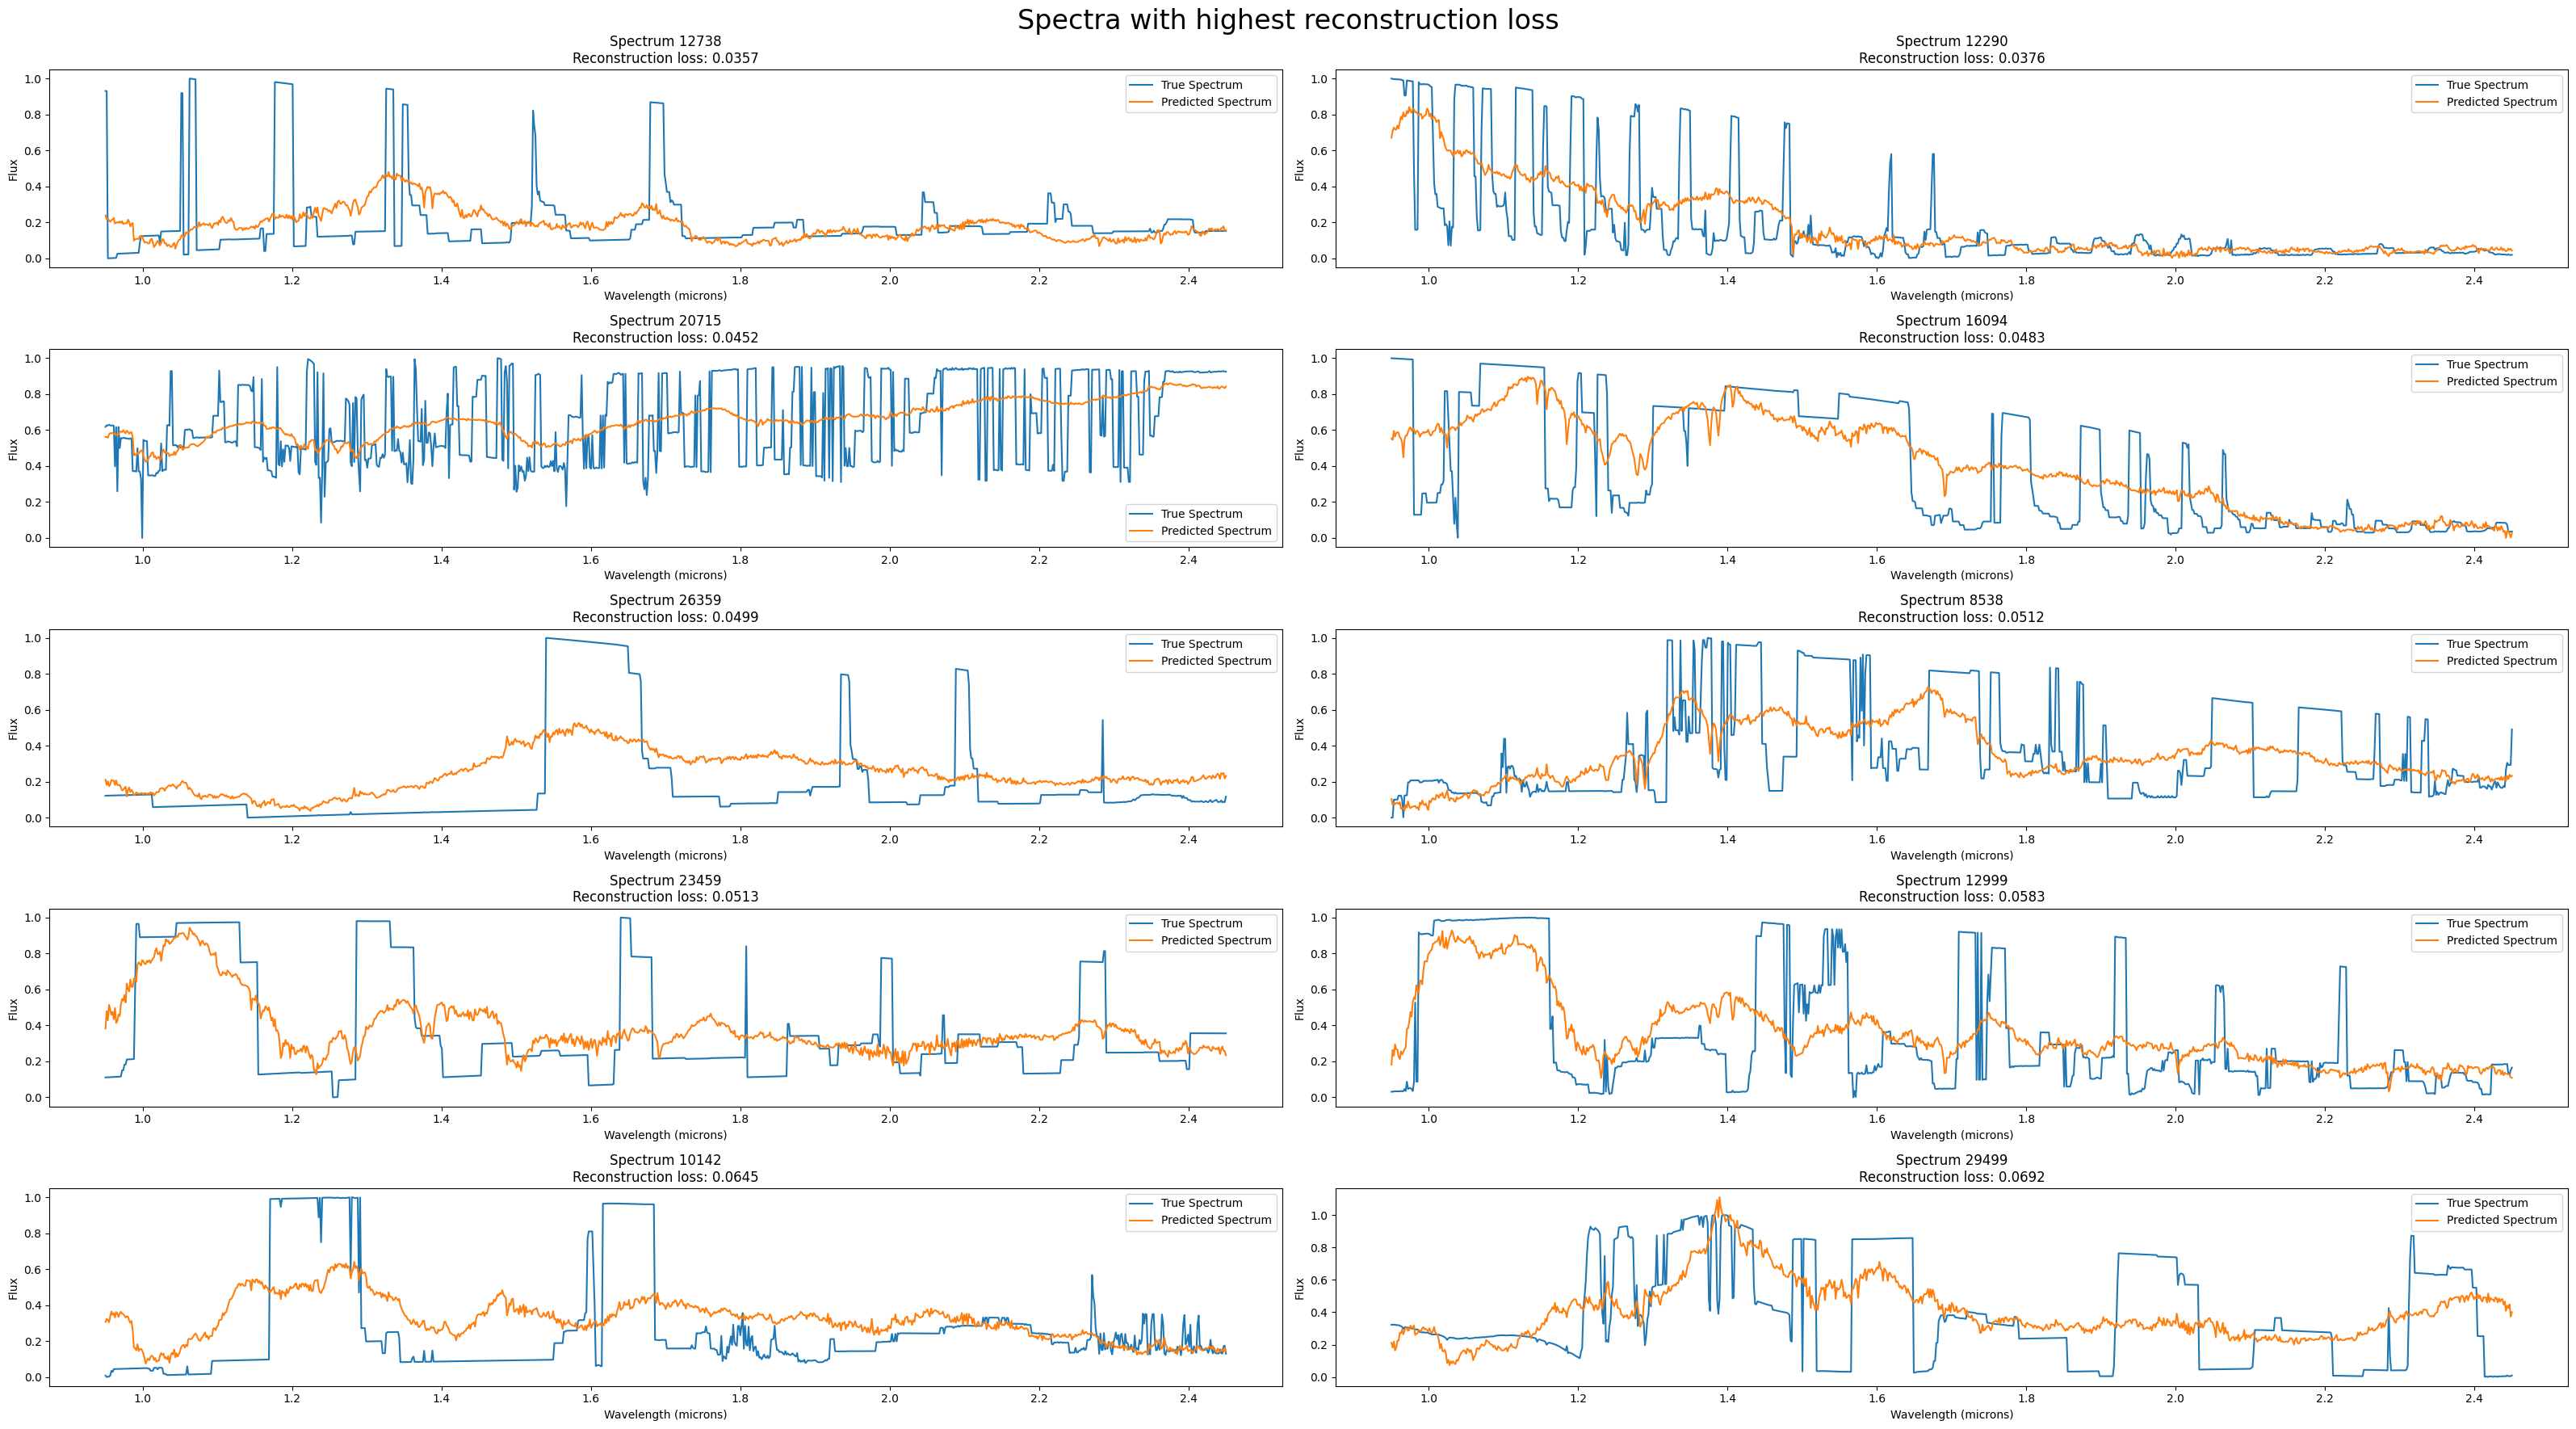

In [9]:
#what do the spectra with the worst (highest) reconstruction loss look like? 
#let's plot the 10 worst spectra... 
worst_indices = np.argsort(reconstruction_loss)[-10:]
print(worst_indices)

fig, axs = plt.subplots(5, 2, figsize=(16*2, 9*2))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    # axs[i].plot(wavelengths, y_test_unscaled[idx], label="True Spectrum")
    # axs[i].plot(wavelengths, y_pred_unscaled[idx], label="Predicted Spectrum")
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx+1}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
plt.show()

[ 7934 16869  3180 11697 14900 12534 16115 28304  5693  8742 24741 29806
 20375 23150 22224  3561 26825 12148  5386 10882  8384  7847  9602 29016
  3059 14739 20383 24671  4462  1758  6400 27963 27068 22522 20965 10318
 15352  7101  6897 20343 16687 29002 16490 19350 26602 19410  5316  5074
   210  4155 15409 13985 23028 25828 17692 19171  9596 18358 27459  7988
 28413 23013 25959 18601 26850 17783 13220 14865 10638 16424 17736 21676
 26249 20620  5100 25025 28530 13233  3581 18217 28993 24397 26526  9777
 25965  3622 14037 29964 27470  7905 12737 12289 20714 16093 26358  8537
 23458 12998 10141 29498]


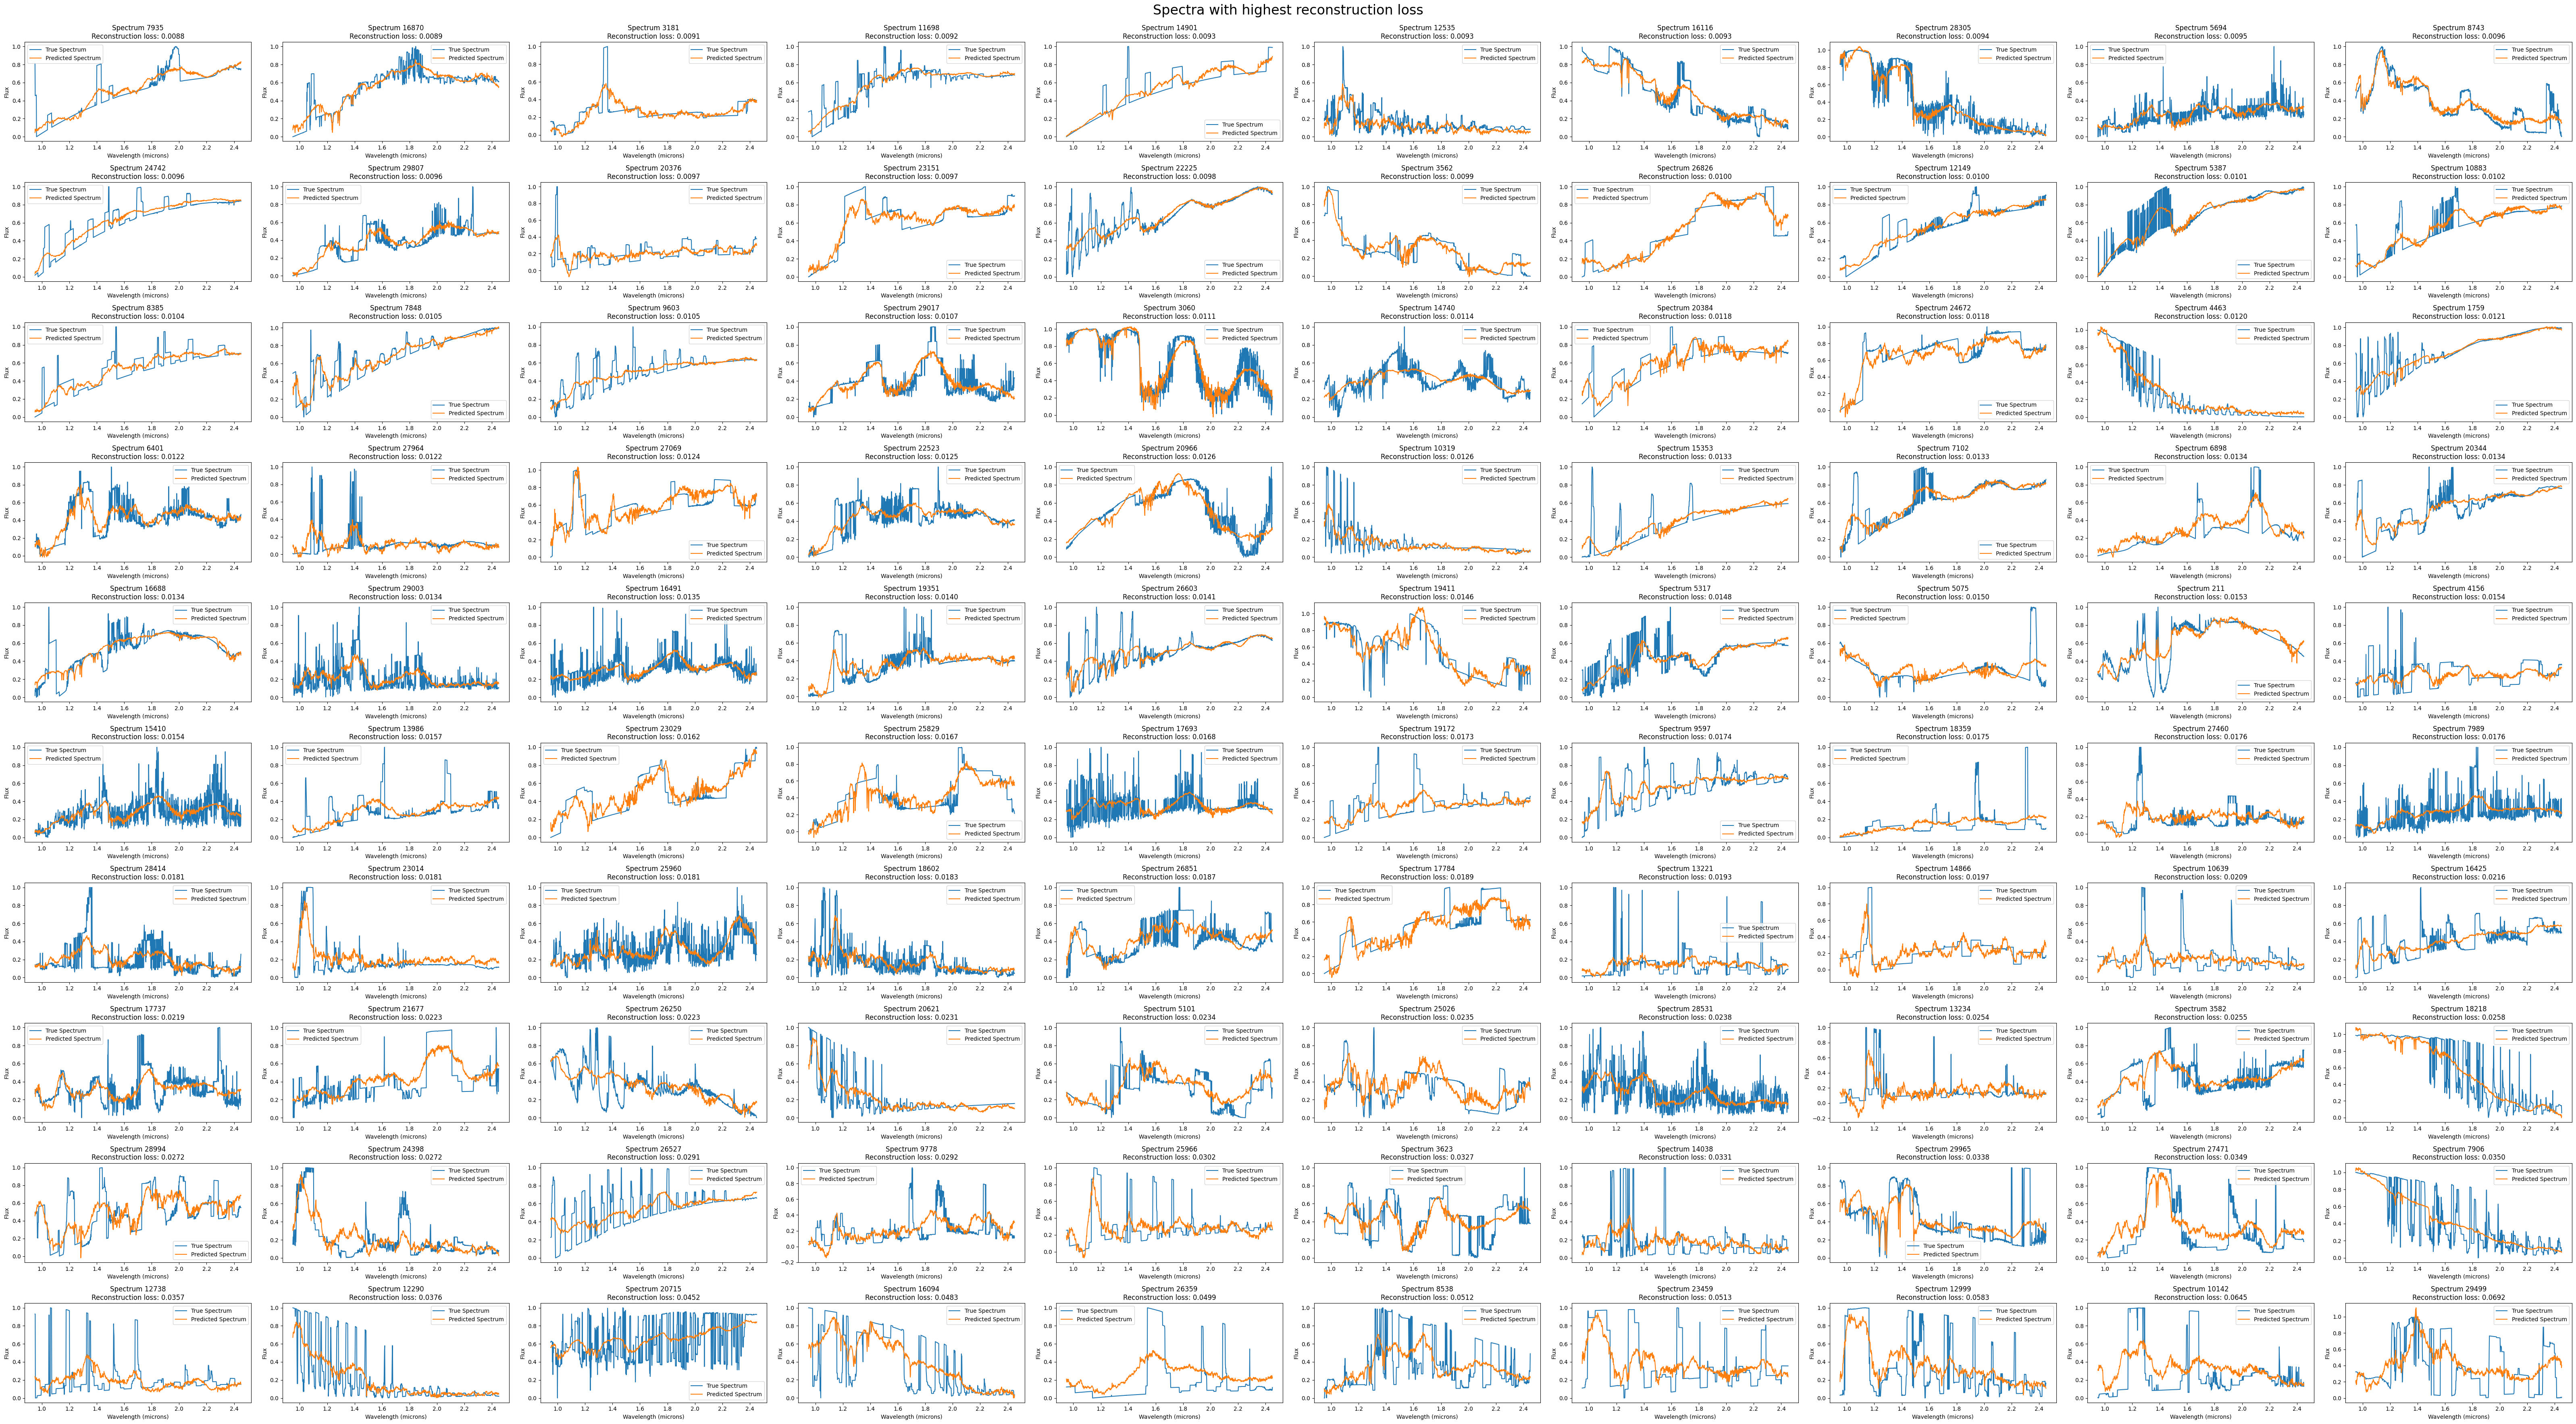

In [10]:
#what about the 100 spectra with the highest reconstruction loss?

worst_indices = np.argsort(reconstruction_loss)[-100:]
print(worst_indices)

fig, axs = plt.subplots(10, 10, figsize=(16*4, 9*4))
axs = axs.flatten()
for i, idx in enumerate(worst_indices):
    # axs[i].plot(wavelengths, y_test_unscaled[idx], label="True Spectrum")
    # axs[i].plot(wavelengths, y_pred_unscaled[idx], label="Predicted Spectrum")
    axs[i].plot(wavelengths, y_test[idx], label="True Spectrum")
    axs[i].plot(wavelengths, y_pred[idx], label="Predicted Spectrum")
    axs[i].set_title(f'Spectrum {idx+1}\nReconstruction loss: {reconstruction_loss[idx]:.4f}')
    axs[i].set_xlabel("Wavelength (microns)")
    axs[i].set_ylabel("Flux")
    axs[i].legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Spectra with highest reconstruction loss", fontsize=24)
plt.show()